In [109]:
from keras.models import Sequential, load_model
import os
import numpy as np
import nibabel as nib
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage import measure
from skimage.transform import resize
from keras_unet.metrics import dice_coef
from keras_unet.models import custom_unet
from keras_unet.losses import jaccard_distance
from sklearn.model_selection import train_test_split
from PIL import Image
from PIL import ImageOps
import fnmatch
import nibabel as nib 
import shutil
%matplotlib inline

In [110]:
def gather_images(data_path):
    images = []
    path = data_path + '\\'
    for f in os.listdir(data_path):
      if '_M' in f:
        images.append(f)
        
      else:
        continue
        #segmentations.append(f.replace('.nii', '_K.nii'))

    #print(images[0], segmentations[0])
    images = np.array(images)
    #segmentations = np.array(segmentations)

    indices = np.array(range(len(images))) # we will use this in the next step.

    return images

In [111]:
model = custom_unet(input_shape=(512,512,2), num_classes=2)
#UNET_KU_EM_UB_train_MA_val
#UNET_MA_EM_UB_train_KU_val
#UNET_MA_KU_EM_train_UB_val
#UNET_MA_KU_UB_train_EM_val
#ALL_INSTITUTION_80-20
model.load_weights("Emory-cysts-10.h5")
model_name = "Emory-cysts-10"

In [112]:
#data_path = r'C:\Users\UAB\data\Emory\data'
data_path = r'C:\Users\UAB\data\Mayo\data'
#data_path = r'C:\Users\UAB\data\UAB\data'
#data_path = r'C:\Users\UAB\data\KU\data'
images = gather_images(data_path)

In [113]:
print(len(images))
print(images[2000])
print(images[0:2])

21037
MA_303868_0_87_L_4_M.npy
['MA_300641_0_105_L_0_M.npy' 'MA_300641_0_105_L_100_M.npy']


In [114]:
image_list = []
#UAB
#phrase_list = ['457036L','457036R']
#Emory
#phrase_list = ['283935R','290336L','290336R','295106L','295106R']
#Mayo
phrase_list = ['380166R','383193L','383193R','385151L','385151R']
#KU
#phrase_list = ['113994L','139486R','157925R','183417R','186714L','186714R','187456L']

for i in range(len(phrase_list)):
    phrase1 = phrase_list[i][:-2]
    phrase2 = phrase_list[i][-1]
    print(phrase1, phrase2)
    for z in range(len(images)):
        name = images[z]
        if phrase1 in name:
            if phrase2 in name:
                image_list.append(name)
            else:
                continue
        else:
            continue

38016 R
38319 L
38319 R
38515 L
38515 R


In [115]:
print(len(image_list))
images = image_list

2727


In [116]:
d = {}
for i in images:
    if i not in d:
        d[i] = len(d)

labels_mapping = list(map(d.get, images))
#print(labels_mapping)

labels = {images[i]:labels_mapping[i] for i in range(len(images))}


In [117]:
print(images[0])

MA_380166_1_120_R_0_M.npy


We need to gather a stack of 32 images for the prediction in the shape (32, 512, 512, 1)


## Use for pre-generated masks


In [ ]:
#divide the number of images avaliable into batches of 32, then we can feed it a batch at a time and 
# then we can append to the larger stack



label_list = []
predictions = []
pred_path = r"D:\EKS-predicted\Mayo\80-10-re"
images = images[0:120]

batches = len(images)//32
left_over = len(images)%32 
print(batches, left_over)


#REMEMBER TO COME BACK FOR LEFTOVERS
for i in range(batches):
    image_stack = np.empty((32,512,512,2))
    for x in range(32*i, (32*(i+1))):
        image = np.load(data_path +"\\"+images[x])
        name = str(images[x][:-5] + 'cyst_seg_emory_10epoch'+ 'K.npy')
        mask  = np.load(data_path +"\\"+ name)
        y = x-(32*i)
        #print(x, y)
        image_stack[y, ...,0] = image[...]
        image_stack[y, ...,1] = mask[...,1]
        label_match = str(images[x][:-5] + 'C.npy')
        #print(label_match)
        label_list.append(label_match)
        
    img_prediction = model.predict(image_stack)
    img_prediction = img_prediction.astype('float')
    #print(img_prediction.shape)
    for z in range(len(img_prediction)):
        #print('saving images')
        img_numb = z + 32*i
        #print(z, img_numb)
        image_save = img_prediction[z,:,:]
        label = label_list[img_numb][:-5]
        filename = str(label + model_name + '_C.npy')
        
        np.save(os.path.join(pred_path, filename), image_save)  


Get left over images predicted on

In [ ]:
left_images = images[-left_over:]
print(len(left_images))

print(left_images[0])

In [ ]:
image_stack = np.empty((32,512,512,2))
label_left = []
for i in range(len(left_images)):
    image = np.load(data_path +"\\"+left_images[i])
    name = str(left_images[i] +'ALL_INSTITUTION_80-10_35ep_'+ 'K.npy')
    mask  = np.load(data_path +"\\"+ name)
    image_stack[i, ...,0] = image[...]
    image_stack[i, ...,1] = mask[...,1]
    label_match = str(left_images[i][:-5] + 'C.npy')
    label_left.append(label_match)
img_prediction = model.predict(image_stack)
img_prediction = img_prediction.astype('float')

for z in range(len(left_images)):
        #print('saving images')
        #print(z, img_numb)
        image_save = img_prediction[z,:,:]
        label = label_left[z][:-5]
        filename = str(label + model_name + '_C.npy')
        np.save(os.path.join(pred_path, filename), image_save)  

## Use to generate kidney AND cyst mask

In [118]:
label_list = []
predictions = []
pred_path = r"D:\EKS-predicted\Emory\EM-model"
images = images[0:200]

batches = len(images)//32
left_over = len(images)%32 
print(batches, left_over)


#REMEMBER TO COME BACK FOR LEFTOVERS
for i in range(batches):
    image_stack = np.empty((32,512,512,2))
    for x in range(32*i, (32*(i+1))):
        image = np.load(data_path +"\\"+images[x])
        y = x-(32*i)
        #print(x, y)
        image_stack[y, ...,0] = image[...]

        label_match = str(images[x][:-5] + 'C.npy')
        #print(label_match)
        label_list.append(label_match)
        
        #predict kidney mask
        if i == 31:
            model = custom_unet(input_shape=(512,512,1), num_classes=2)
            model.load_weights('Emory-kindeys-35.h5')
            #print('load model complete')
            img_prediction_K = model.predict(X[:,:,:,0])
            img_prediction_K = img_prediction_K.astype('uint8')
                
            image_stack[...,1] = img_prediction_K[:,:,:,1]    
    
    #predict our cyst 

    img_prediction = model.predict(image_stack)
    img_prediction = img_prediction.astype('float')
    #print(img_prediction.shape)
    for z in range(len(img_prediction)):
        #print('saving images')
        img_numb = z + 32*i
        #print(z, img_numb)
        image_save = img_prediction[z,:,:]
        label = label_list[img_numb][:-5]
        filename = str(label + model_name + '_C.npy')
        
        np.save(os.path.join(pred_path, filename), image_save) 

6 8


In [119]:
left_images = images[-left_over:]
print(len(left_images))

print(left_images[0])

8
MA_380166_2_138_R_40_M.npy


In [104]:
image_stack = np.empty((32,512,512,2))
label_left = []
for i in range(len(left_images)):
    image = np.load(data_path +"\\"+left_images[i])
    
    image_stack[i, ...,0] = image[...]
    
    label_match = str(left_images[i][:-5] + 'C.npy')
    label_left.append(label_match)
    
    #predict kidney mask
    if i == 31:
        model = custom_unet(input_shape=(512,512,1), num_classes=2)
        model.load_weights('ALL_INSTITUTION_80-10_35ep.h5')
        #print('load model complete')
        img_prediction_K = model.predict(X[:,:,:,0])
        img_prediction_K = img_prediction_K.astype('uint8')

        image_stack[...,1] = img_prediction_K[:,:,:,1] 
    
img_prediction = model.predict(image_stack)
img_prediction = img_prediction.astype('float')

for z in range(len(left_images)):
        #print('saving images')
        #print(z, img_numb)
        image_save = img_prediction[z,:,:]
        label = label_left[z][:-5]
        filename = str(label + model_name + '_C.npy')
        np.save(os.path.join(pred_path, filename), image_save)  

## Everything below here is to look at predictions, and needs to be cleaned up
im just too afraid to delete it


In [49]:
prediction = np.load(r"D:\EKS-predicted\Mayo\80-10-re\MA_380166_1_120_R_108_cyst_seg_allinst_1epoch_C.npy")
image = np.load(r"C:\Users\UAB\data\Mayo\data\MA_380166_1_120_R_108_M.npy")
#kidney = np.load(r"C:\Users\UAB\data\Emory\data\EM_283935_2_126_R_27_M.npy")
#kidneyPRED = np.load(r"C:\Users\UAB\data\Mayo\data\MA_380166_1_120_R_100_ALL_INSTITUTION_80-10_35ep_K.npy")
true = np.load(r"C:\Users\UAB\data\Mayo\data\MA_380166_1_120_R_108_C.npy")

0.0

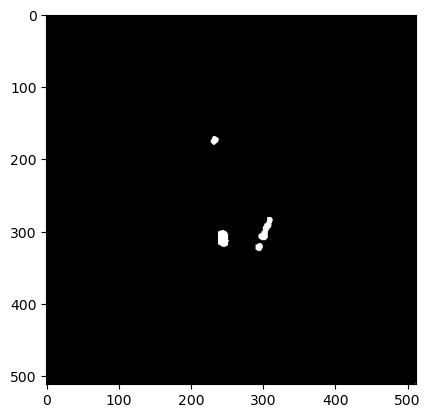

In [50]:
plt.imshow(prediction[:,:,1], cmap='gray')
prediction.min()

dtype('uint8')

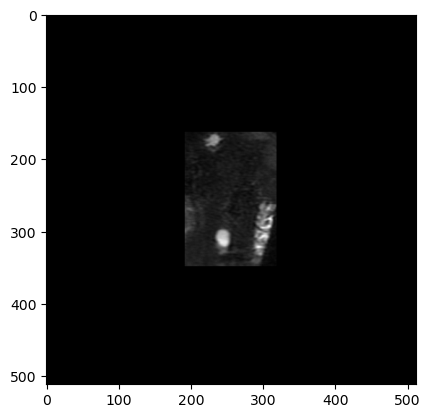

In [51]:
plt.imshow(image, cmap='gray')
image.min()
image.dtype

In [19]:
plt.imshow(kidneyPRED[:,:,1], cmap='gray')

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

<Figure size 640x480 with 0 Axes>

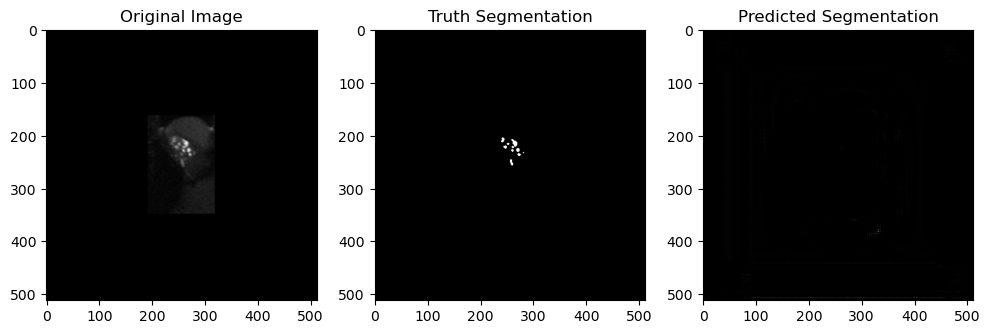

In [17]:
plt.figure()
f, axarr = plt.subplots(nrows = 1, ncols = 3, figsize=(10,10))
f.tight_layout()

axarr[0].imshow(image, cmap="gray")
axarr[0].title.set_text('Original Image')
axarr[1].imshow(true, cmap='gray')
axarr[1].title.set_text('Truth Segmentation')
axarr[2].imshow(prediction[:,:,1], cmap='gray')
axarr[2].title.set_text('Predicted Segmentation')

In [37]:
img_path = r"C:\Users\UAB\data\Emory\Cyst Predictions -3"
name = 'first cyst prediction.png'

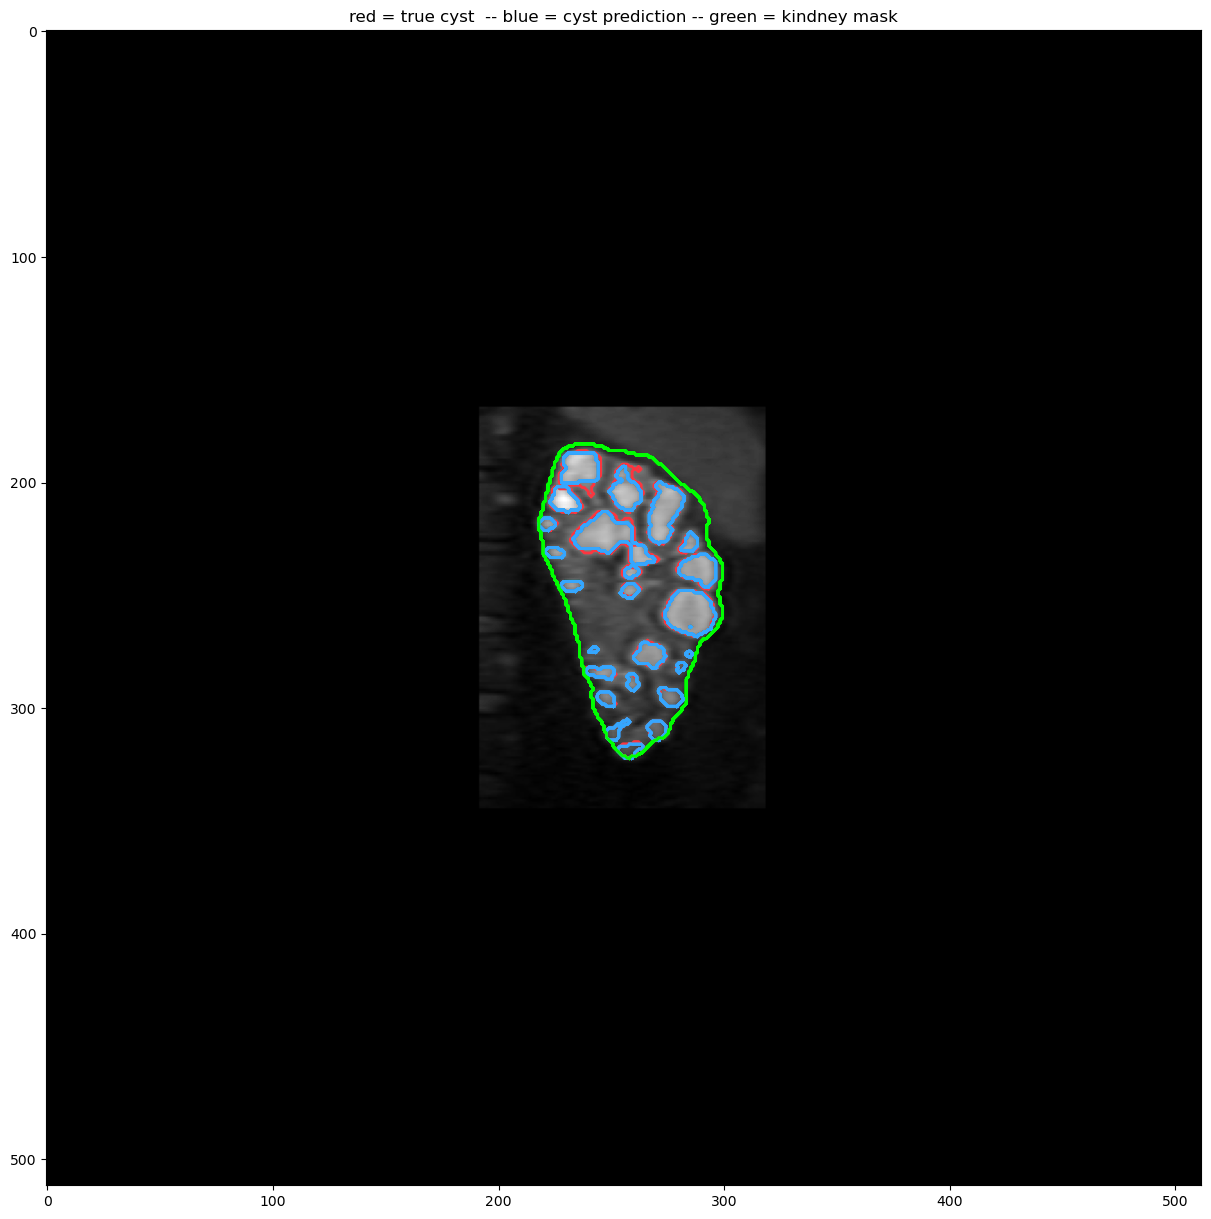

In [38]:
fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot()
ax.imshow(image, cmap=plt.cm.gray)

contours = measure.find_contours(true, 0.8)
for j,contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0],color='#FB3640', lw=2)
    contours = measure.find_contours(prediction[:,:,1], 0.8)
    for contour in contours:
        ax.plot(contour[:, 1], contour[:, 0],color='#35A7FF', lw=2)
        contours = measure.find_contours(kidney, 0.8)
    for contour in contours:
        ax.plot(contour[:, 1], contour[:, 0],color='#00FF00', lw=2)
        #contours = measure.find_contours(model_4[:,:,slice_num], 0.8)  
   # for contour in contours:
       # ax.plot(contour[:, 1], contour[:, 0],color='#FFFF00', lw=2)
       # contours = measure.find_contours(original[:,:,slice_num], 0.8)

ax.axis('image')
ax.title.set_text('red = true cyst  -- blue = cyst prediction -- green = kindney mask')
fig.savefig(os.path.join(img_path,name))

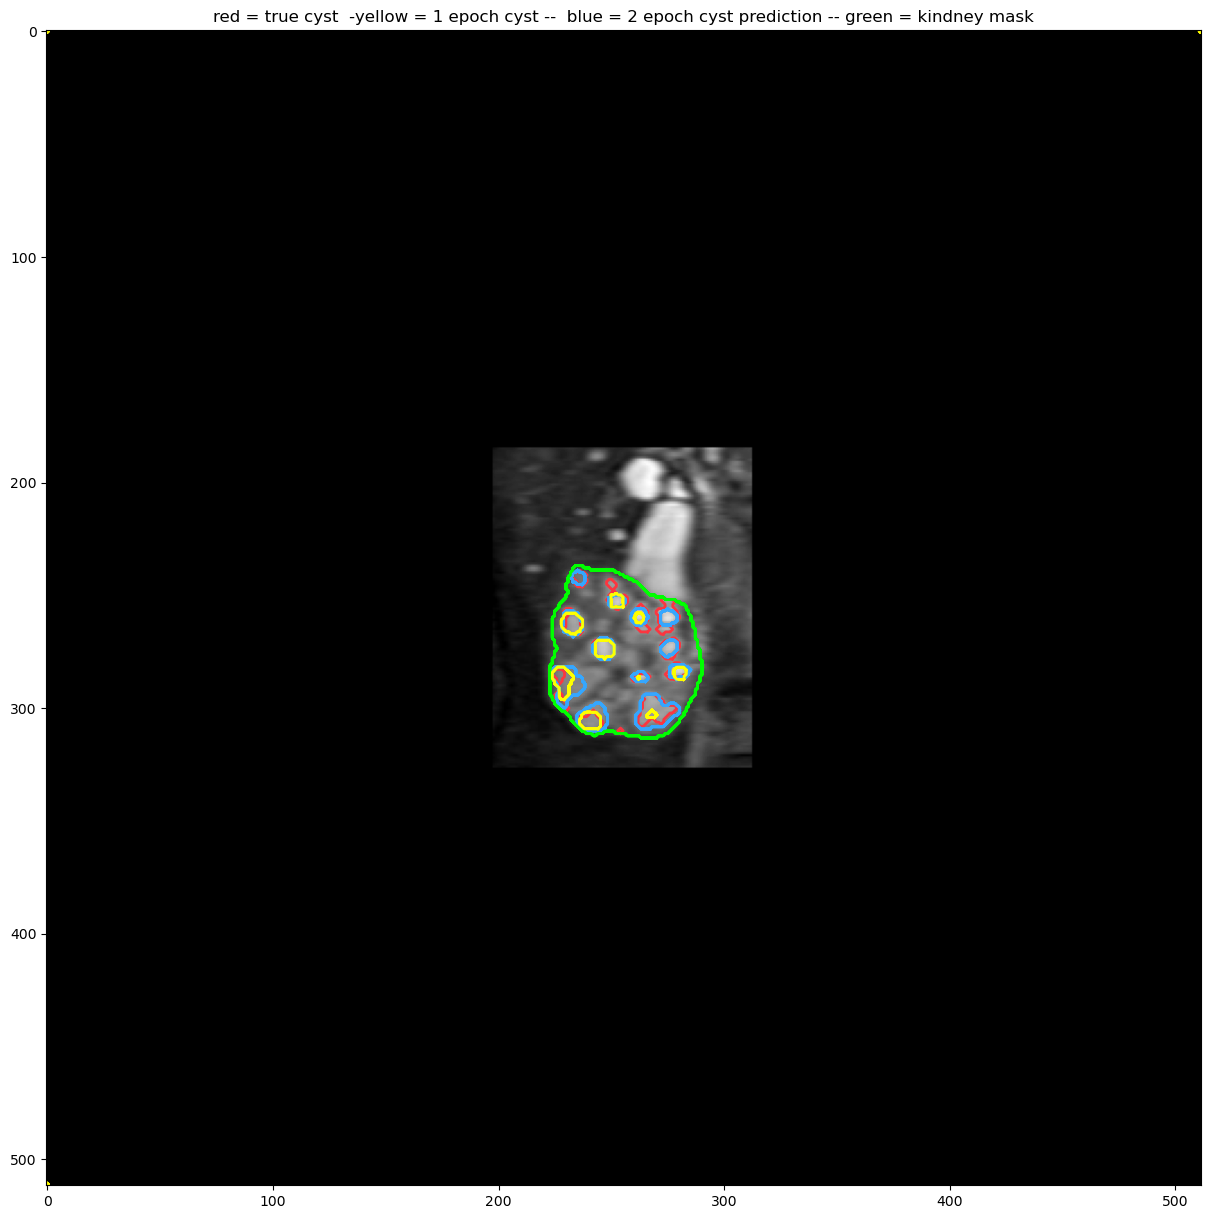

In [28]:
prediction2 = np.load(r"C:\Users\UAB\data\Emory\CystPredictions-2\EM_200922_0_144_L_100_test_P.npy")
prediction1 = np.load(r"C:\Users\UAB\data\Emory\CystPredictions\EM_200922_0_144_L_100_test_P.npy")
name = 'two epoch.png'

fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot()
ax.imshow(image, cmap=plt.cm.gray)

contours = measure.find_contours(true, 0.8)
for j,contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0],color='#FB3640', lw=2)
    contours = measure.find_contours(prediction1[:,:,1], 0.8)
    for contour in contours:
        ax.plot(contour[:, 1], contour[:, 0],color='#35A7FF', lw=2)
        contours = measure.find_contours(kidney, 0.8)
    for contour in contours:
        ax.plot(contour[:, 1], contour[:, 0],color='#00FF00', lw=2)
        contours = measure.find_contours(prediction2[:,:,1], 0.8)  
    for contour in contours:
        ax.plot(contour[:, 1], contour[:, 0],color='#FFFF00', lw=2)
       # contours = measure.find_contours(original[:,:,slice_num], 0.8)

ax.axis('image')
ax.title.set_text('red = true cyst  -yellow = 1 epoch cyst --  blue = 2 epoch cyst prediction -- green = kindney mask')
fig.savefig(os.path.join(img_path,name))

In [105]:
p1 = np.load(r"D:\EKS-predicted\Mayo\80-10-re\MA_380166_1_120_R_71_cyst_seg_allinst_35epoch_C.npy")
p2 = np.load(r"D:\EKS-predicted\Mayo\80-10-re\MA_380166_1_120_R_71_cyst_seg_allinst_1epoch_C.npy")
p3 = np.load(r"D:\EKS-predicted\Mayo\80-10-re\MA_380166_1_120_R_72_cyst_seg_emory_10epoch_C.npy")
image = np.load(r"C:\Users\UAB\data\Mayo\data\MA_380166_1_120_R_71_M.npy")

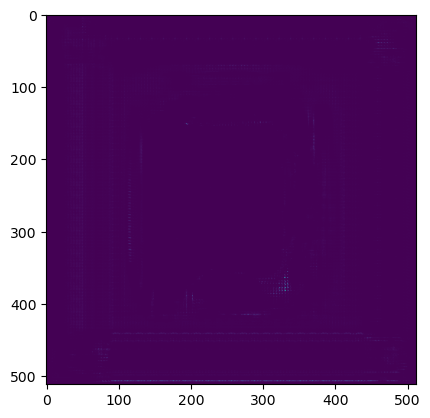

In [108]:
plt.imshow(p1[:,:,1])

In [120]:
test = np.load(r"D:\EKS-predicted\Emory\EM-model\MA_380166_2_138_R_36_Emory-cysts-10_C.npy")

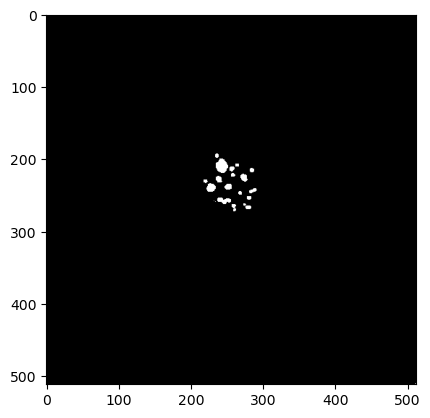

In [122]:
plt.imshow(test[:,:,1], cmap='gray')